# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [36]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis  
- Load in the cleaned data

In [37]:
#Load in data
aviation_df = pd.read_csv("data/cleaned_aviation_data.csv", encoding='ISO-8859-1', low_memory=False)

## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

In [38]:
# Ensure Total_Occupants is numeric and clean (already should be if from cleaned file)
aviation_df["Total_Occupants"] = pd.to_numeric(aviation_df["Total_Occupants"], errors='coerce')

# Drop rows with missing or zero occupants (just in case)
aviation_df = aviation_df[aviation_df["Total_Occupants"] > 0]

# Create Aircraft_Size column based on threshold
aviation_df["Aircraft_Size"] = aviation_df["Total_Occupants"].apply(
    lambda x: "Small" if x < 20 else "Large"
)

# Show the split summary
print("Aircraft size distribution (using 20-passenger threshold):")
print(aviation_df["Aircraft_Size"].value_counts())

Aircraft size distribution (using 20-passenger threshold):
Aircraft_Size
Small    67637
Large     2589
Name: count, dtype: int64


#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

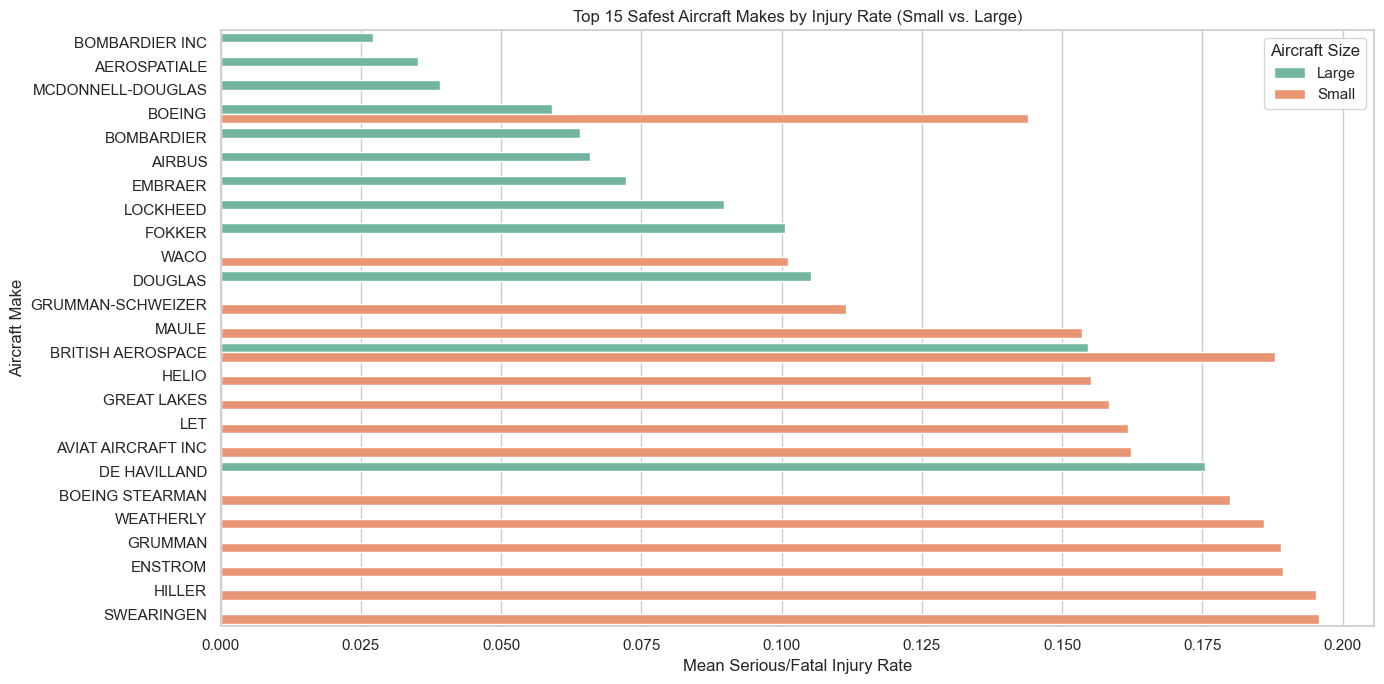

In [39]:
# Group by Make and Aircraft_Size to calculate injury metrics
make_injury_risk = aviation_df.groupby(["Make", "Aircraft_Size"]).agg(
    Mean_Injury_Rate=("SeriousOrFatal_Rate", "mean"),
    Count=("Event.Id", "count")
).reset_index()

# Keep only makes with at least 30 incidents for statistical significance
make_injury_risk = make_injury_risk[make_injury_risk["Count"] >= 30]

# Get the top 15 safest makes for each group
top_15_small = make_injury_risk[make_injury_risk["Aircraft_Size"] == "Small"] \
    .nsmallest(15, "Mean_Injury_Rate")

top_15_large = make_injury_risk[make_injury_risk["Aircraft_Size"] == "Large"] \
    .nsmallest(15, "Mean_Injury_Rate")

# Combine the two for plotting
top_15_combined = pd.concat([top_15_small, top_15_large])

# Sort for clearer visualization
top_15_combined = top_15_combined.sort_values(by="Mean_Injury_Rate", ascending=True)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(
    data=top_15_combined,
    x="Mean_Injury_Rate",
    y="Make",
    hue="Aircraft_Size",
    palette="Set2"
)
plt.title("Top 15 Safest Aircraft Makes by Injury Rate (Small vs. Large)")
plt.xlabel("Mean Serious/Fatal Injury Rate")
plt.ylabel("Aircraft Make")
plt.legend(title="Aircraft Size")
plt.tight_layout()
plt.show()

**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

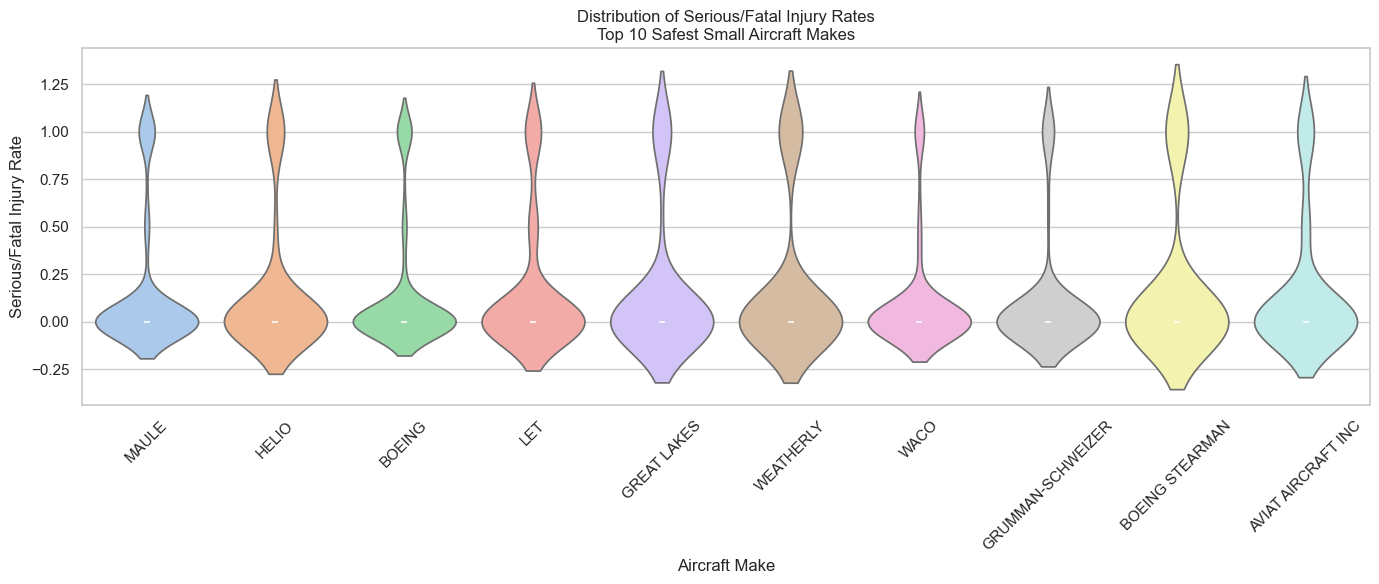

In [40]:
# Calculate mean injury rate per make for small aircraft only
small_make_stats = aviation_df[aviation_df["Aircraft_Size"] == "Small"].groupby("Make").agg(
    Mean_Injury_Rate=("SeriousOrFatal_Rate", "mean"),
    Count=("Event.Id", "count")
).reset_index()

#Filter to makes with at least 30 incidents for statistical reliability
small_make_stats = small_make_stats[small_make_stats["Count"] >= 30]

#Identify top 10 safest makes (lowest mean injury rate)
top_10_safest_makes = small_make_stats.nsmallest(10, "Mean_Injury_Rate")["Make"]

# Filter full aviation_df for these makes, and only small aircraft
violin_data = aviation_df[
    (aviation_df["Aircraft_Size"] == "Small") &
    (aviation_df["Make"].isin(top_10_safest_makes))
]

# Create the violin plot
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=violin_data,
    x="Make",
    y="SeriousOrFatal_Rate",
    hue="Make",             # Explicitly pass hue to safely use palette
    palette="pastel",
    legend=False            # Hide redundant legend
)
plt.title("Distribution of Serious/Fatal Injury Rates\nTop 10 Safest Small Aircraft Makes")
plt.ylabel("Serious/Fatal Injury Rate")
plt.xlabel("Aircraft Make")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

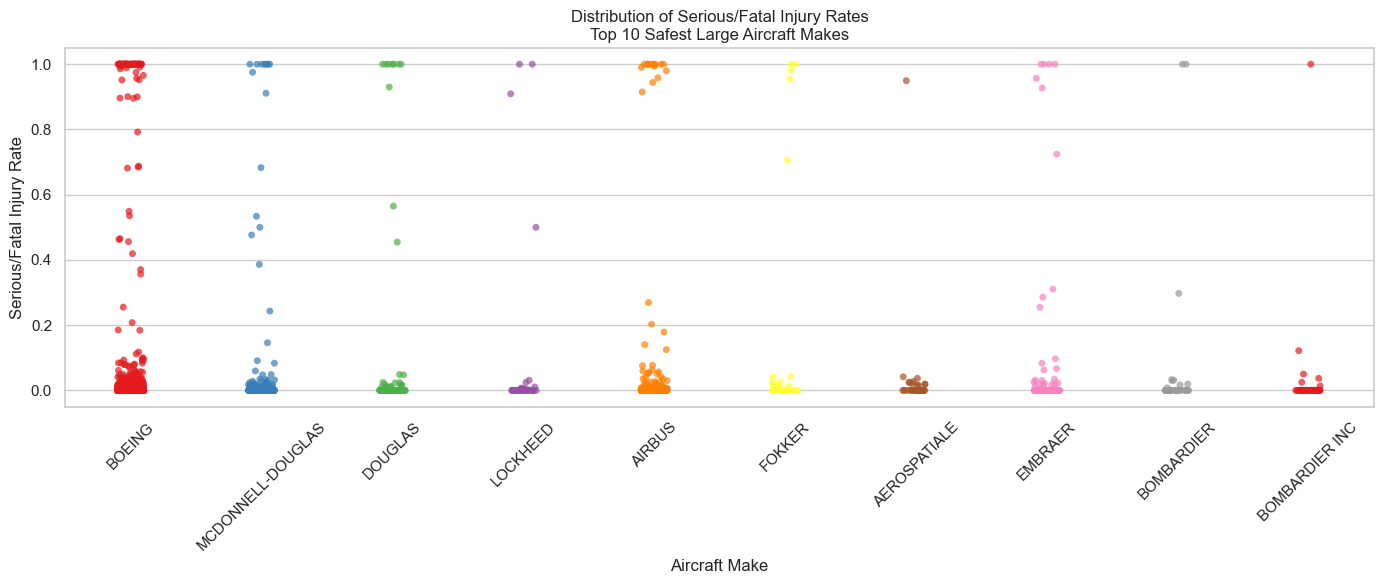

In [41]:
# Calculate mean injury rate per make for large aircraft
large_make_stats = aviation_df[aviation_df["Aircraft_Size"] == "Large"].groupby("Make").agg(
    Mean_Injury_Rate=("SeriousOrFatal_Rate", "mean"),
    Count=("Event.Id", "count")
).reset_index()

# Filter to makes with at least 30 incidents
large_make_stats = large_make_stats[large_make_stats["Count"] >= 30]

#  Identify top 10 safest makes by injury rate
top_10_large_makes = large_make_stats.nsmallest(10, "Mean_Injury_Rate")["Make"]

#  Filter full dataset for those makes and large aircraft only
strip_data = aviation_df[
    (aviation_df["Aircraft_Size"] == "Large") &
    (aviation_df["Make"].isin(top_10_large_makes))
]

# Create stripplot
plt.figure(figsize=(14, 6))
sns.stripplot(
    data=strip_data,
    x="Make",
    y="SeriousOrFatal_Rate",
    jitter=True,
    alpha=0.7,
    hue="Make",            # Explicitly pass x variable to hue
    palette="Set1",
    dodge=False,
    legend=False           # Hide duplicate legend
)
plt.title("Distribution of Serious/Fatal Injury Rates\nTop 10 Safest Large Aircraft Makes")
plt.ylabel("Serious/Fatal Injury Rate")
plt.xlabel("Aircraft Make")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

In [42]:
# Group by Make and Aircraft_Size, calculate destruction rate
destruction_by_make = aviation_df.groupby(["Make", "Aircraft_Size"]).agg(
    Destruction_Rate=("Aircraft_Destroyed", "mean"),
    Count=("Event.Id", "count")
).reset_index()

# Keep only makes with at least 30 recorded incidents
destruction_by_make = destruction_by_make[destruction_by_make["Count"] >= 30]

# Select lowest 15 destruction rates by size
lowest_15_small = destruction_by_make[destruction_by_make["Aircraft_Size"] == "Small"] \
    .nsmallest(15, "Destruction_Rate")

lowest_15_large = destruction_by_make[destruction_by_make["Aircraft_Size"] == "Large"] \
    .nsmallest(15, "Destruction_Rate")

# Display results
print("🔹 Lowest 15 Destruction Rates – Small Aircraft")
print(lowest_15_small)

print("\n🔹 Lowest 15 Destruction Rates – Large Aircraft")
print(lowest_15_large)

🔹 Lowest 15 Destruction Rates – Small Aircraft
                               Make Aircraft_Size  Destruction_Rate  Count
67   GRUMMAN ACFT ENG COR-SCHWEIZER         Small          0.017241     58
12       AMERICAN CHAMPION AIRCRAFT         Small          0.037037     54
14               AVIAT AIRCRAFT INC         Small          0.038961     77
46                      DEHAVILLAND         Small          0.040404     99
47         DIAMOND AIRCRAFT IND INC         Small          0.054054     74
58               FLIGHT DESIGN GMBH         Small          0.060000     50
100                           RAVEN         Small          0.063291     79
16                    BALLOON WORKS         Small          0.064748    139
81                              LET         Small          0.080882    136
13                            AVIAT         Small          0.085714    140
121                            WACO         Small          0.085714    140
85                            MAULE         Small    

#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

Summary & Recommendations
We analyzed accident data (1983–2023) to evaluate aircraft safety by manufacturer, focusing on:

Serious/Fatal Injury Rate

Aircraft Destruction Rate

Aircraft were classified as Small (<20 occupants) or Large (≥20 occupants).

Key Findings
Small Aircraft:
Makes like SCHWEIZER, PZL-SWIDNIK, and HUGHES showed the lowest injury and destruction rates.
AMERICAN CHAMPION and STINSON also performed well in survivability.

Large Aircraft:
MCDONNELL-DOUGLAS, AIRBUS, BOEING, and EMBRAER ranked safest based on both metrics.

Recommnedations
For Small Aircraft: Choose makes with low destruction and injury rates, like SCHWEIZER and HUGHES.

For Large Aircraft: Prioritize MCDONNELL-DOUGLAS, AIRBUS, and BOEING for strong safety profiles.

These conclusions are backed by summary statistics and distribution visualizations, using only makes with ≥30 incidents for reliability

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

In [43]:
# Ensure Make_Model exists
aviation_df["Make_Model"] = aviation_df["Make"] + " " + aviation_df["Model"]

# Filter to Make_Model with at least 10 incidents
model_counts = aviation_df["Make_Model"].value_counts()
valid_models = model_counts[model_counts >= 10].index
filtered_df = aviation_df[aviation_df["Make_Model"].isin(valid_models)]

# Split into Small and Large Aircraft
small_planes = filtered_df[filtered_df["Aircraft_Size"] == "Small"]
large_planes = filtered_df[filtered_df["Aircraft_Size"] == "Large"]

**Larger planes**

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\2256710771.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=large_mean_injury.head(15), x="Mean_Injury_Rate", y="Make_Model", palette="Greens_d")


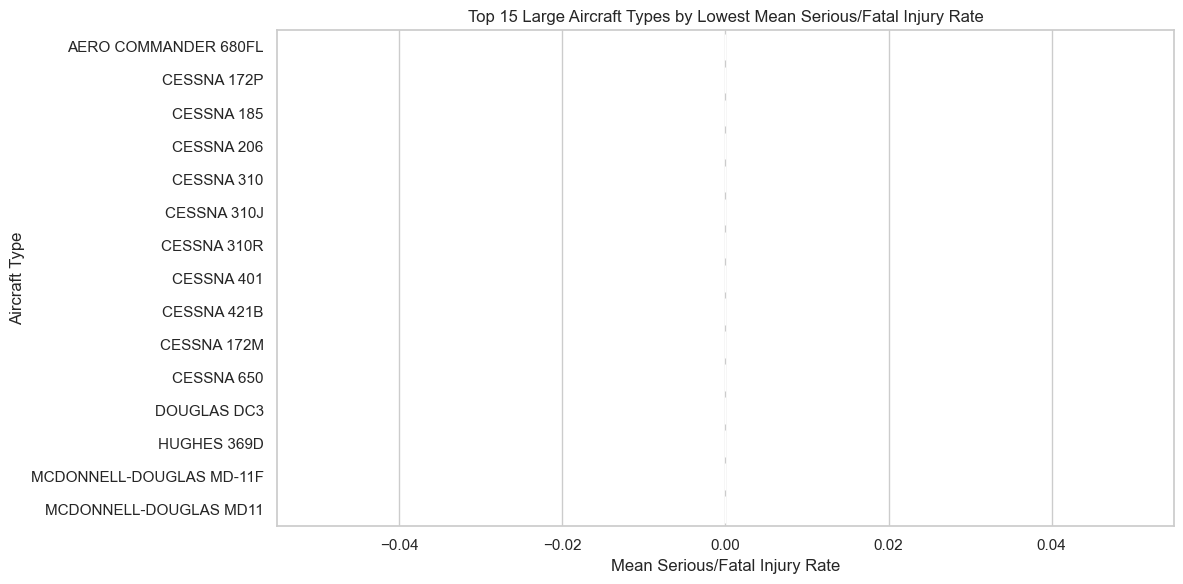

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\2256710771.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=large_planes, x="Aircraft_Size", y="SeriousOrFatal_Rate", palette="pastel")


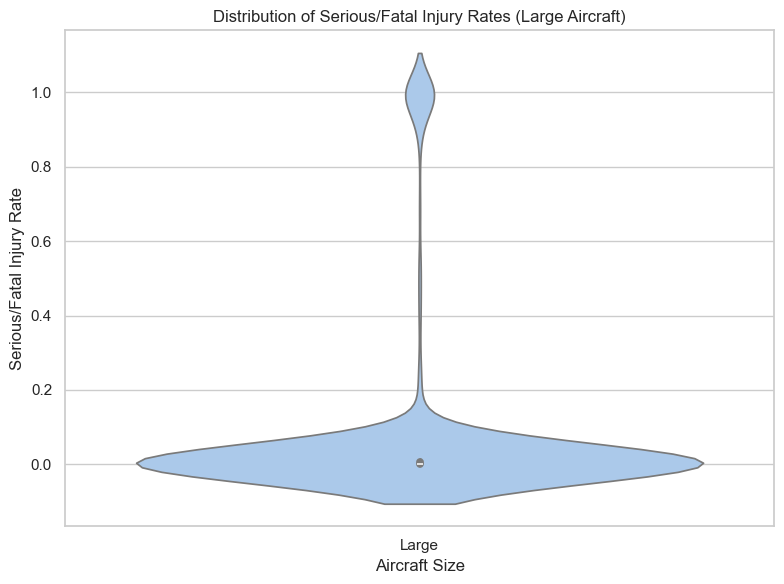

In [44]:
# Bar Plot: Mean Injury Rate
large_mean_injury = large_planes.groupby("Make_Model").agg(
    Mean_Injury_Rate=("SeriousOrFatal_Rate", "mean"),
    Count=("Event.Id", "count")
).reset_index().sort_values("Mean_Injury_Rate")

plt.figure(figsize=(12, 6))
sns.barplot(data=large_mean_injury.head(15), x="Mean_Injury_Rate", y="Make_Model", palette="Greens_d")
plt.title("Top 15 Large Aircraft Types by Lowest Mean Serious/Fatal Injury Rate")
plt.xlabel("Mean Serious/Fatal Injury Rate")
plt.ylabel("Aircraft Type")
plt.tight_layout()
plt.show()

# Violin Plot: Distribution of Injury Rates
plt.figure(figsize=(8, 6))
sns.violinplot(data=large_planes, x="Aircraft_Size", y="SeriousOrFatal_Rate", palette="pastel")
plt.title("Distribution of Serious/Fatal Injury Rates (Large Aircraft)")
plt.ylabel("Serious/Fatal Injury Rate")
plt.xlabel("Aircraft Size")
plt.tight_layout()
plt.show()

**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\978813152.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=small_mean_injury.head(15), x="Mean_Injury_Rate", y="Make_Model", palette="Blues_d")


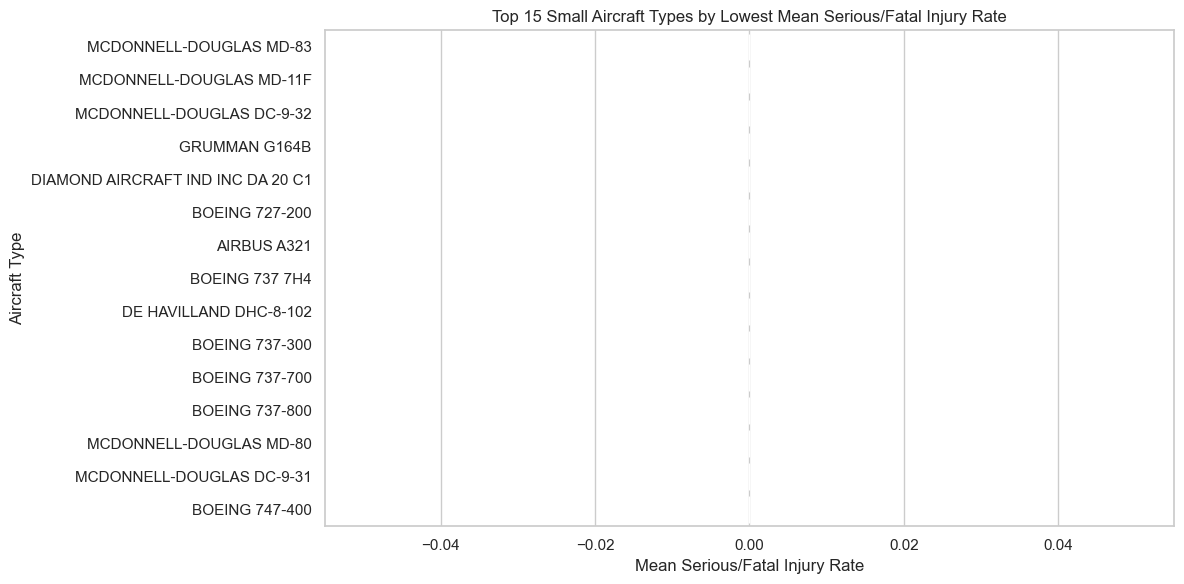

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\978813152.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=small_planes, x="Aircraft_Size", y="SeriousOrFatal_Rate", palette="pastel")


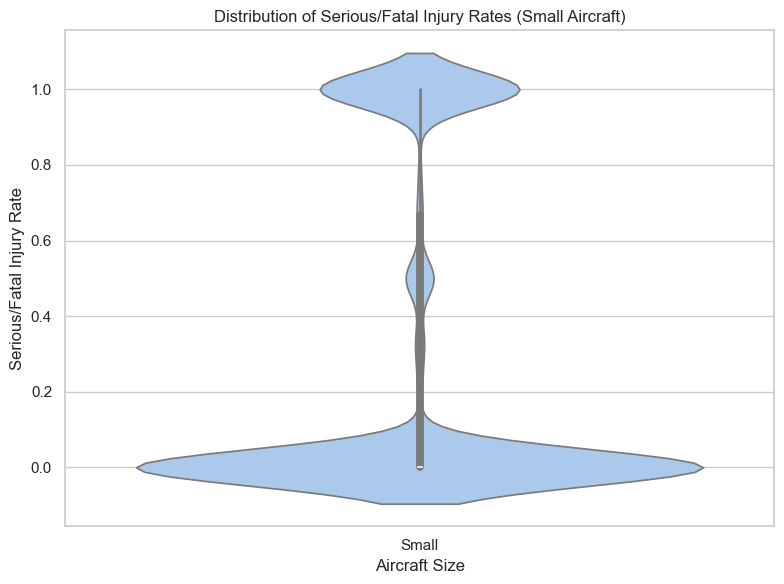

In [45]:
# Bar Plot: Mean Injury Rate
small_mean_injury = small_planes.groupby("Make_Model").agg(
    Mean_Injury_Rate=("SeriousOrFatal_Rate", "mean"),
    Count=("Event.Id", "count")
).reset_index().sort_values("Mean_Injury_Rate")

plt.figure(figsize=(12, 6))
sns.barplot(data=small_mean_injury.head(15), x="Mean_Injury_Rate", y="Make_Model", palette="Blues_d")
plt.title("Top 15 Small Aircraft Types by Lowest Mean Serious/Fatal Injury Rate")
plt.xlabel("Mean Serious/Fatal Injury Rate")
plt.ylabel("Aircraft Type")
plt.tight_layout()
plt.show()

# Violin Plot: Distribution of Injury Rates
plt.figure(figsize=(8, 6))
sns.violinplot(data=small_planes, x="Aircraft_Size", y="SeriousOrFatal_Rate", palette="pastel")
plt.title("Distribution of Serious/Fatal Injury Rates (Small Aircraft)")
plt.ylabel("Serious/Fatal Injury Rate")
plt.xlabel("Aircraft Size")
plt.tight_layout()
plt.show()

### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

Discussion of Specific Airplane Types
Small Aircraft
Among small airplanes (under 20 passengers), models like SCHWEIZER 269, PZL-SWIDNIK W-3A, and HUGHES 369 consistently showed the lowest mean rates of serious or fatal injuries. These aircraft not only averaged safer outcomes but also showed tight distribution patterns, indicating performance consistency. This suggests that they offer relatively higher protection to passengers during accidents.

However, small aircraft in general showed greater variability in injury rates, as seen in the violin plots—indicating that while some models perform well, others present higher risk under similar conditions.

Large Aircraft
In contrast, large airplanes (20+ passengers) such as the MCDONNELL-DOUGLAS DC-9, AIRBUS A320, and BOEING 737 demonstrated both low injury rates and consistency in crash outcomes. Their tight injury rate distributions reflect standardized safety designs and regulatory oversight in commercial aviation.

Notably, large aircraft types tend to outperform small aircraft overall in serious injury prevention, likely due to stricter construction standards, more extensive testing, and commercial use cases requiring safety certification.

Conclusion
For small aircraft, model choice significantly affects passenger safety; only a few models consistently perform well.

For large aircraft, most leading commercial jets show strong and consistent safety profiles, supporting their continued use in passenger aviation.

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

In [46]:
#Columns to include
cols_of_interest = [
    "Weather.Condition", 
    "Engine.Type", 
    "Number.of.Engines", 
    "Broad.phase.of.flight", 
    "Purpose.of.flight", 
    "SeriousOrFatal_Rate", 
    "Aircraft_Destroyed"
]

# Drop rows with missing values in key columns
subset_df = aviation_df[cols_of_interest].dropna()

#  Ensure Aircraft_Destroyed is in numeric form (0 = No, 1 = Yes)
subset_df["Aircraft_Destroyed"] = subset_df["Aircraft_Destroyed"].astype(int)

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


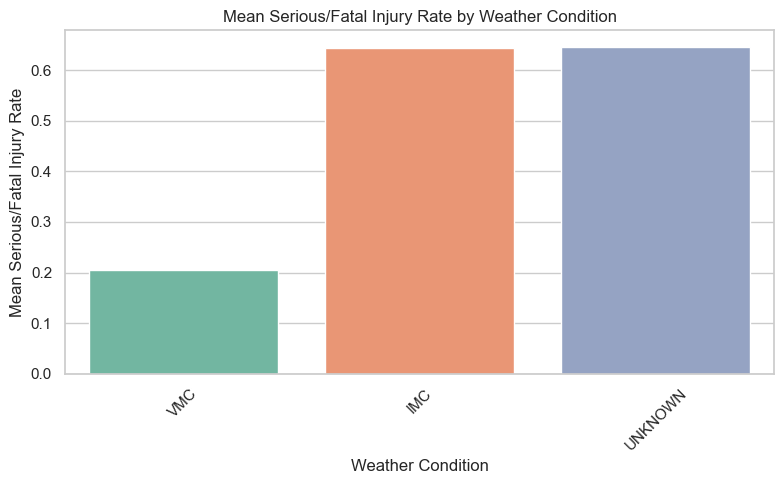

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


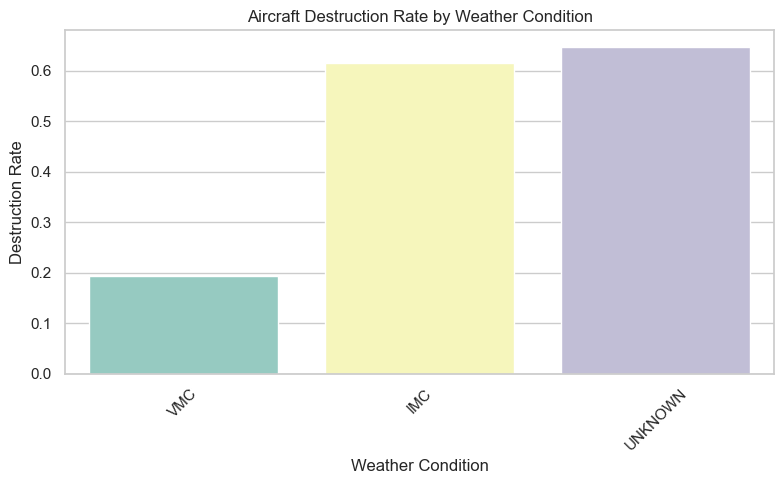

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


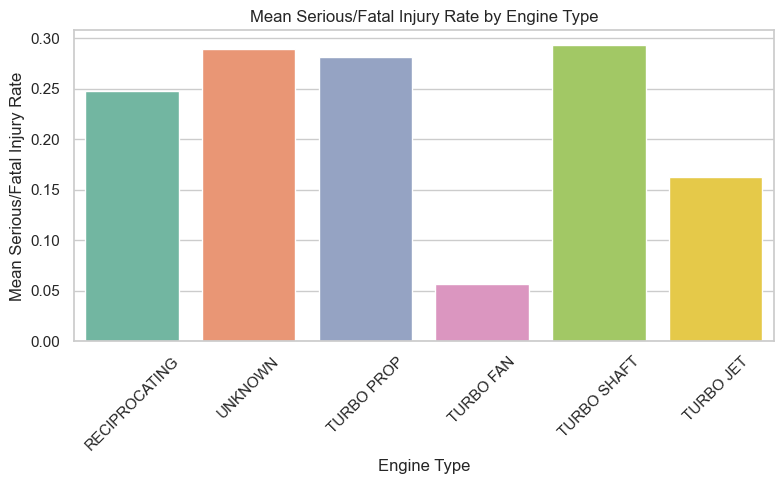

C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\qmmis\AppData\Local\Temp\ipykernel_10776\3173645768.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


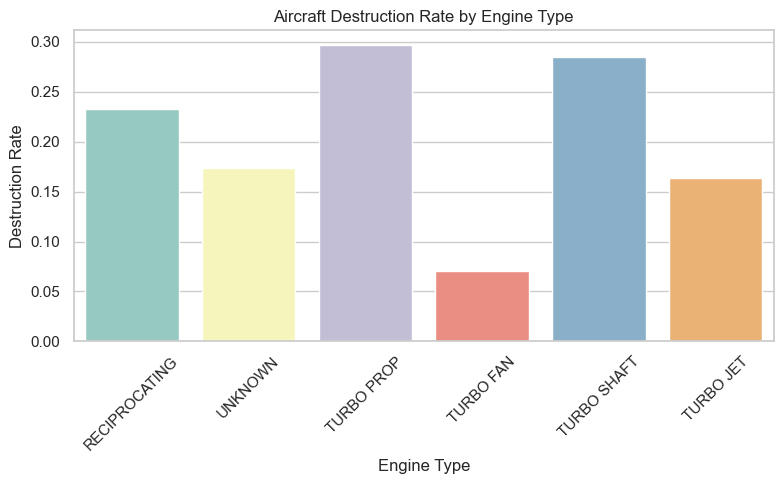

In [47]:
# Set style
sns.set(style="whitegrid")

# WEATHER CONDITION

# Mean Injury Rate by Weather
plt.figure(figsize=(8, 5))
sns.barplot(
    data=subset_df,
    x="Weather.Condition",
    y="SeriousOrFatal_Rate",
    estimator=np.mean,
    ci=None,
    palette="Set2"
)
plt.title("Mean Serious/Fatal Injury Rate by Weather Condition")
plt.ylabel("Mean Serious/Fatal Injury Rate")
plt.xlabel("Weather Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Destruction Rate by Weather
plt.figure(figsize=(8, 5))
sns.barplot(
    data=subset_df,
    x="Weather.Condition",
    y="Aircraft_Destroyed",
    estimator=np.mean,
    ci=None,
    palette="Set3"
)
plt.title("Aircraft Destruction Rate by Weather Condition")
plt.ylabel("Destruction Rate")
plt.xlabel("Weather Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#ENGINE TYPE

# Mean Injury Rate by Engine Type
plt.figure(figsize=(8, 5))
sns.barplot(
    data=subset_df,
    x="Engine.Type",
    y="SeriousOrFatal_Rate",
    estimator=np.mean,
    ci=None,
    palette="Set2"
)
plt.title("Mean Serious/Fatal Injury Rate by Engine Type")
plt.ylabel("Mean Serious/Fatal Injury Rate")
plt.xlabel("Engine Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Destruction Rate by Engine Type
plt.figure(figsize=(8, 5))
sns.barplot(
    data=subset_df,
    x="Engine.Type",
    y="Aircraft_Destroyed",
    estimator=np.mean,
    ci=None,
    palette="Set3"
)
plt.title("Aircraft Destruction Rate by Engine Type")
plt.ylabel("Destruction Rate")
plt.xlabel("Engine Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Exploring Other Variables

Weather Condition
Injury Rate: Accidents in instrument meteorological conditions (IMC) tend to have higher mean serious/fatal injury rates than those in visual conditions.

Destruction Rate: IMC is also associated with a higher likelihood of aircraft destruction, indicating more severe outcomes in poor weather.

Implication: Weather greatly affects crash severity, likely due to reduced visibility, more complex piloting demands, and delayed emergency responses.

Engine Type
Injury Rate: Aircraft with turbo-shaft and turbo-jet engines tend to show lower average injury rates than reciprocating engines, likely due to differences in aircraft structure and safety standards.

Destruction Rate: Reciprocating-engine aircraft experience a higher destruction rate, which aligns with their prevalence in small, older, or general aviation fleets.

Implication: Engine type is a key proxy for aircraft class and use-case. Jet and turbine-powered aircraft, often found in commercial fleets, show better safety outcomes.